In [6]:
import os
os.listdir("../results")


['cicids_adaptive_model.joblib',
 'cicids_LogisticRegression_runtime_summary.csv',
 'cicids_RandomForest_runtime_summary.csv',
 'cicids_RandomForest_shap_summary.png',
 'cicids_results.csv',
 'cicids_runtime_summary.csv',
 'cicids_shap_summary.png',
 'cicids_SVM_runtime_summary.csv',
 'cicids_XGBoost_runtime_summary.csv',
 'cicids_XGBoost_shap_summary.png',
 'compare_retraining.csv',
 'LogisticRegression_nsl_runtime_summary.csv',
 'nsl_adaptive_model.joblib',
 'nsl_baseline_runtime.csv',
 'nsl_LogisticRegression_runtime_summary.csv',
 'nsl_RandomForest_runtime_summary.csv',
 'nsl_results.csv',
 'nsl_runtime_summary.csv',
 'nsl_shap_summary.png',
 'nsl_SVM_runtime_summary.csv',
 'nsl_XGBoost_runtime_summary.csv',
 'retraining_efficiency_plot.png',
 'shap_per_window']

In [10]:
# %% [markdown]
# # Clean Summary for NSL-KDD & CICIDS

# %%
import pandas as pd
import glob, os

# Path to your results folder
results_path = "../results"

# Get all *_runtime_summary.csv files
csv_files = glob.glob(os.path.join(results_path, "*_runtime_summary.csv"))

summary = []

for file in csv_files:
    df = pd.read_csv(file)
    
    # Extract dataset and model from filename
    fname = os.path.basename(file)
    if fname.startswith("cicids"):
        dataset = "CICIDS"
    elif "nsl" in fname.lower():
        dataset = "NSL"
    else:
        dataset = "Unknown"
        
    model_name = fname.replace(f"{dataset.lower()}_", "").replace("_runtime_summary.csv", "")
    
    # Skip unknown or empty models
    if not model_name or model_name.lower() in ["unknown_model", "baseline"]:
        continue
    
    # Filter extreme memory deltas (< -10 MB)
    df = df[df['mem_diff_mb'] > -10]
    
    # Compute averages
    avg_acc = df['post_acc'].mean() * 100
    avg_f1 = df['post_f1'].mean() * 100
    avg_time = df['retrain_time_s'].mean()
    avg_mem = df['mem_diff_mb'].mean()
    
    summary.append({
        "Dataset": dataset,
        "Model": model_name,
        "Avg Accuracy (%)": round(avg_acc, 2),
        "Avg F1-Score (%)": round(avg_f1, 2),
        "Avg Retrain Time (s)": round(avg_time, 2),
        "Avg Memory Δ (MB)": round(avg_mem, 2)
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary)

# Separate by dataset for clarity
nsl_summary = summary_df[summary_df["Dataset"] == "NSL"].reset_index(drop=True)
cicids_summary = summary_df[summary_df["Dataset"] == "CICIDS"].reset_index(drop=True)

# Display clean tables
print("🔹 NSL-KDD Summary:\n")
print(nsl_summary.to_string(index=False))

print("\n🔹 CICIDS Summary:\n")
print(cicids_summary.to_string(index=False))


🔹 NSL-KDD Summary:

Dataset               Model  Avg Accuracy (%)  Avg F1-Score (%)  Avg Retrain Time (s)  Avg Memory Δ (MB)
    NSL  LogisticRegression              55.8             48.15                  2.39               1.21
    NSL  LogisticRegression              56.2             47.76                  2.10               0.40
    NSL        RandomForest              98.0             97.99                  0.31              17.27
    NSL runtime_summary.csv              94.0             93.69                  0.23              11.21
    NSL                 SVM              54.4             41.34                  2.64               7.86
    NSL             XGBoost              88.4             88.06                  0.86               0.08

🔹 CICIDS Summary:

Dataset               Model  Avg Accuracy (%)  Avg F1-Score (%)  Avg Retrain Time (s)  Avg Memory Δ (MB)
 CICIDS  LogisticRegression              98.1             99.04                  0.63                0.0
 CICIDS        

In [8]:
import pandas as pd
df = pd.read_csv("../results/cicids_LogisticRegression_runtime_summary.csv")
print(df.columns)
print(df.head())


Index(['window', 'pre_acc', 'pre_f1', 'post_acc', 'post_f1', 'retrain_time_s',
       'mem_diff_mb', 'features'],
      dtype='object')
   window  pre_acc  pre_f1  post_acc   post_f1  retrain_time_s  mem_diff_mb  \
0       0    0.999  0.9995     0.981  0.990409            0.63          0.0   

                                            features  
0  destination port,max packet length,packet leng...  


In [13]:
import pandas as pd

df = pd.read_csv("../results/cicids_LogisticRegression_runtime_summary.csv")
print(df[['window','pre_acc','pre_f1','retrain_time_s','mem_diff_mb']])

   window  pre_acc  pre_f1  retrain_time_s  mem_diff_mb
0       0    0.999  0.9995            0.63          0.0



==== Performance Trends for NSL Dataset ====


C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_34828\1426440265.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


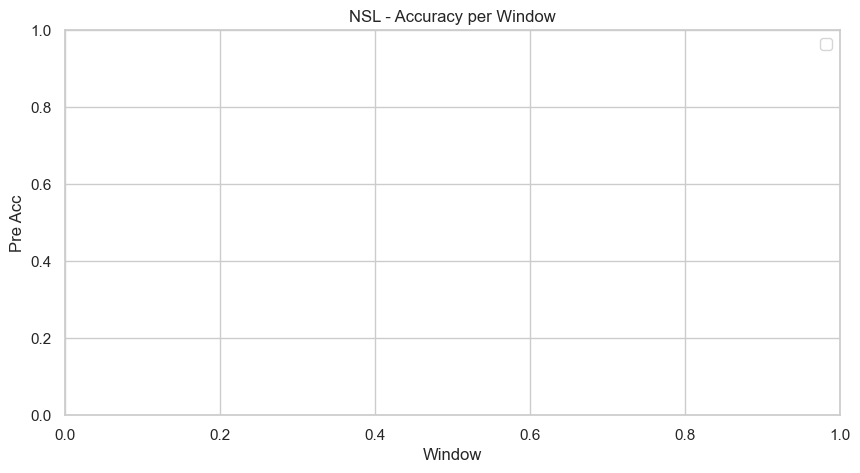

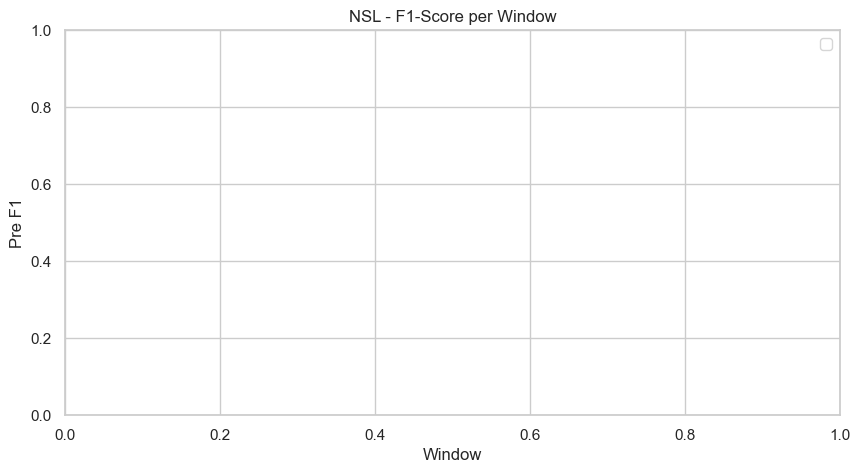

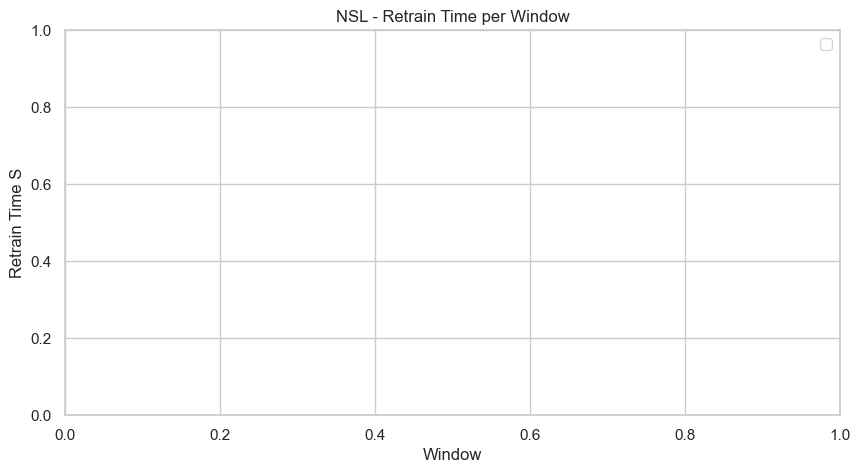

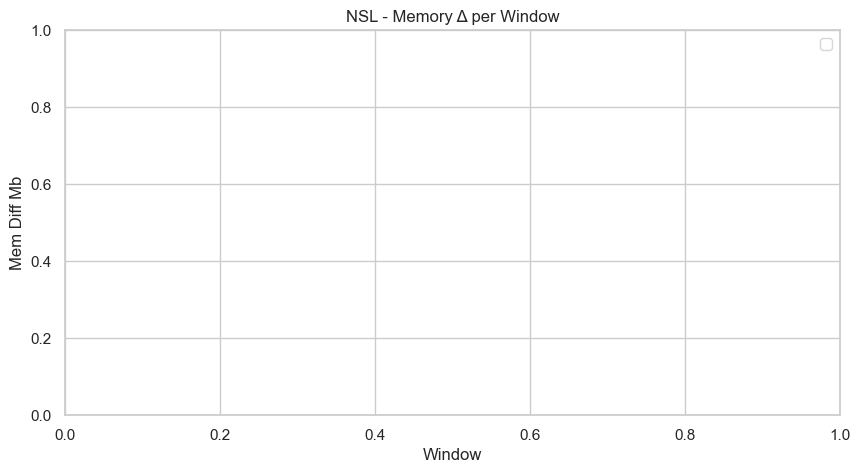


==== Performance Trends for CICIDS Dataset ====


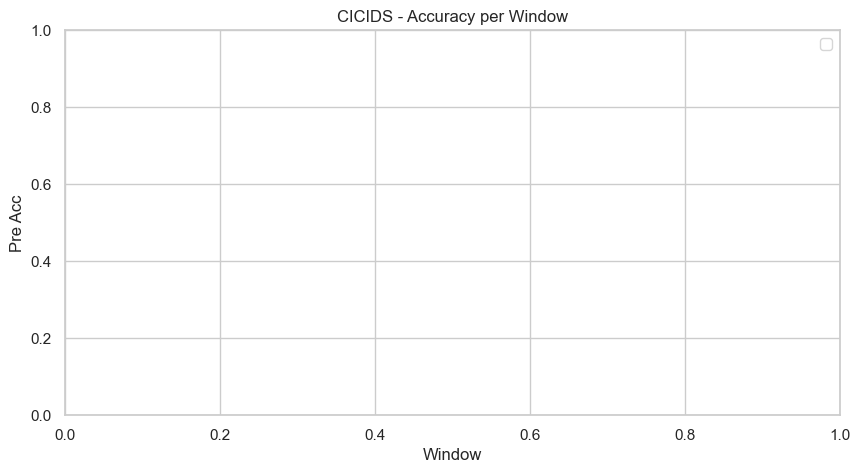

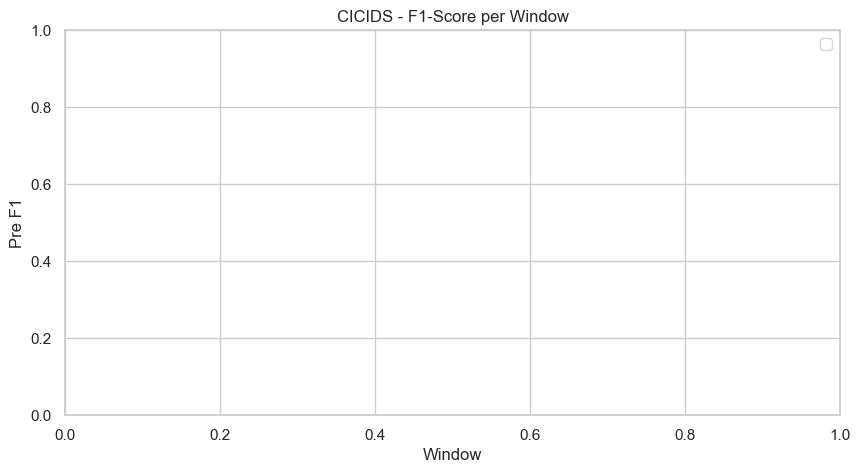

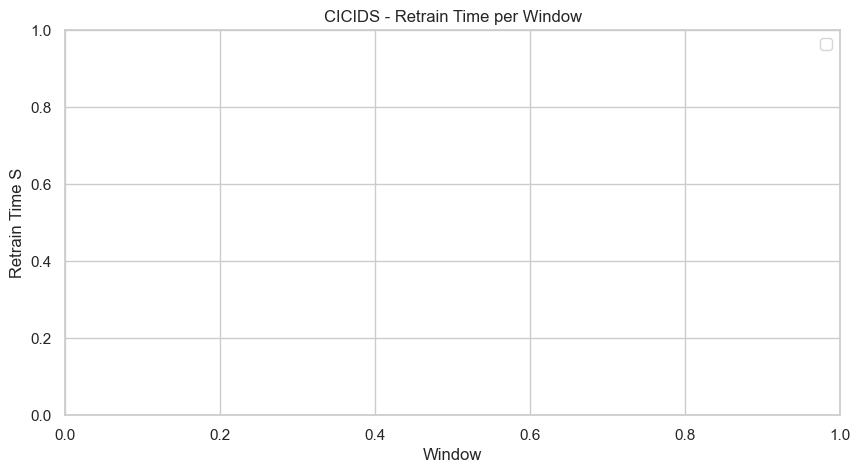

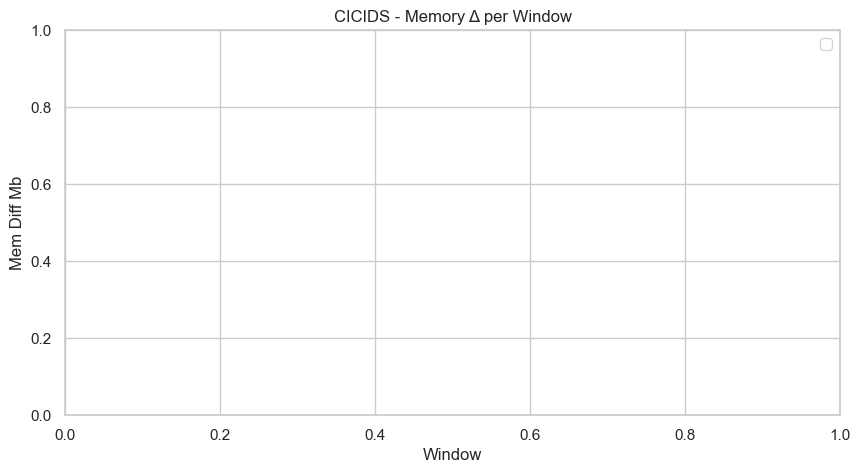

In [11]:
# performance_trends.ipynb
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Settings ----------------
results_folder = "../results"  # adjust if needed
datasets = ["nsl", "cicids"]
models = ["LogisticRegression", "RandomForest", "SVM", "XGBoost"]

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# ---------------- Function to plot per dataset ----------------
def plot_per_window(df, metric, title):
    """
    df: DataFrame containing runtime summary
    metric: column to plot ("pre_acc", "pre_f1", "retrain_time_s", "mem_diff_mb")
    title: plot title
    """
    plt.figure()
    for model in models:
        model_file = [f for f in os.listdir(results_folder) if model in f.lower() and df.dataset.iloc[0] in f.lower() and "runtime_summary" in f]
        if not model_file:
            continue
        path = os.path.join(results_folder, model_file[0])
        model_df = pd.read_csv(path)
        plt.plot(model_df["window"], model_df[metric], marker='o', label=model)
        
        # highlight retraining events
        drift_idx = model_df[model_df["retrain_time_s"] > 0].index
        plt.scatter(drift_idx, model_df.loc[drift_idx, metric], color='red', s=60, zorder=5)

    plt.title(title)
    plt.xlabel("Window")
    plt.ylabel(metric.replace("_"," ").title())
    plt.legend()
    plt.show()

# ---------------- Loop over datasets ----------------
for ds in datasets:
    print(f"\n==== Performance Trends for {ds.upper()} Dataset ====")
    # Dummy df just to pass dataset name to function
    dummy_df = pd.DataFrame({"dataset":[ds]})
    
    # Accuracy
    plot_per_window(dummy_df, "pre_acc", f"{ds.upper()} - Accuracy per Window")
    # F1-Score
    plot_per_window(dummy_df, "pre_f1", f"{ds.upper()} - F1-Score per Window")
    # Retrain Time
    plot_per_window(dummy_df, "retrain_time_s", f"{ds.upper()} - Retrain Time per Window")
    # Memory Δ
    plot_per_window(dummy_df, "mem_diff_mb", f"{ds.upper()} - Memory Δ per Window")
